In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import wfdb  # For å lese .dat og .hea filer
from config import DATASET_DIR
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import F1Score, AUC

## Download the data
This dataset is very large, will take several hours to download.

In [ ]:
!curl -O https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip

In [ ]:
!unzip -q ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip
!ls

## Preprocessing

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


Duration of ECG signal: 10.0 seconds


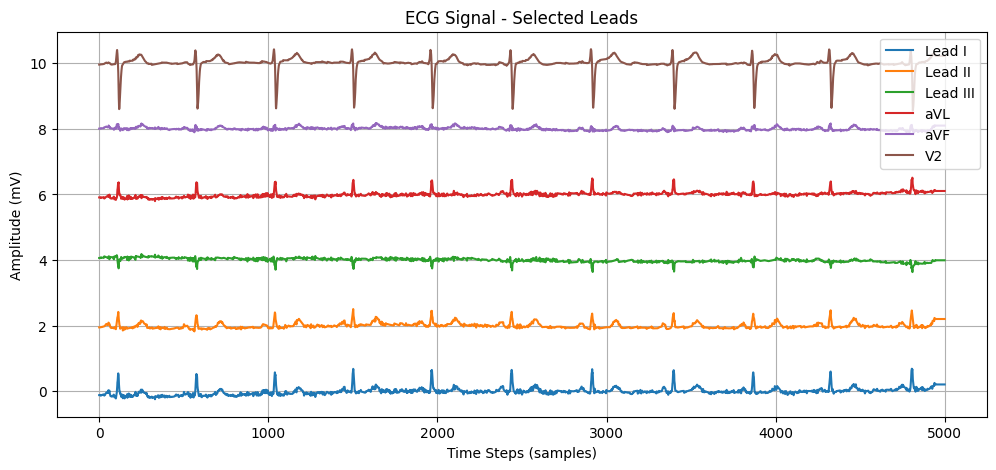

Unique label values: [0. 1.]
Distribution of diagnostic classes:
NORM: 9438.0 samples (43.30%)
MI: 4134.0 samples (18.96%)
STTC: 5078.0 samples (23.29%)
CD: 4891.0 samples (22.44%)
HYP: 2258.0 samples (10.36%)


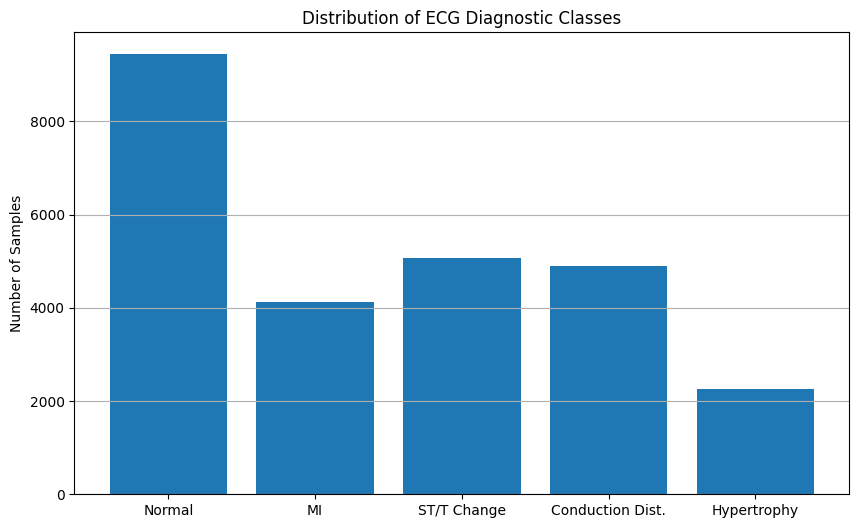

Number of multi-label records: 4390 (20.14%)


In [3]:
### **1️⃣ Load Dataset**
# Load metadata
df = pd.read_csv(os.path.join(DATASET_DIR, "ptbxl_database.csv"))
df_labels = pd.read_csv(os.path.join(DATASET_DIR, "scp_statements.csv"))

# Display dataset information
display(df.head())



### **2️⃣ Load & Preprocess ECG Signals Efficiently**
def load_ecg(record_name):
    """Loads ECG signal from PTB-XL .dat files."""
    file_path = os.path.join(DATASET_DIR, record_name)
    record = wfdb.rdsamp(file_path)[0]  # Extract raw ECG signal
    return record

# Load all ECGs into a NumPy array
ecg_signals = np.array([load_ecg(f) for f in df["filename_hr"]])

# Display duration of ECG signals
sampling_rate = 500  # PTB-XL default sampling rate
duration = ecg_signals.shape[1] / sampling_rate
print(f"Duration of ECG signal: {duration} seconds")



### **3️⃣ Select Relevant Leads**
FOCUS_LEADS = [0, 1, 2, 4, 5, 7]  # Lead I, Lead II, Lead III, aVL, aVF, V2
FOCUS_LEAD_NAMES = ["Lead I", "Lead II", "Lead III", "aVL", "aVF", "V2"]

# Extract only the selected leads
ecg_signals = ecg_signals[:, :, FOCUS_LEADS]



### **4️⃣ Visualize ECG Signals**
def plot_ecg(ecg_data, leads, title):
    """Plots ECG signals for selected leads with offsets."""
    plt.figure(figsize=(12, 5))
    for i in range(ecg_data.shape[1]):
        plt.plot(ecg_data[:, i] + (i * 2), label=leads[i])  # Offset each lead
    plt.title(title)
    plt.xlabel("Time Steps (samples)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot selected leads
plot_ecg(ecg_signals[0], FOCUS_LEAD_NAMES, "ECG Signal - Selected Leads")



### **5️⃣ Normalize ECG Signals**
# Normalize ECGs using vectorized StandardScaler
scaler = StandardScaler()
ecg_signals = np.array([scaler.fit_transform(ecg) for ecg in ecg_signals])



### **6️⃣ Zero-Padding & Truncating**
def preprocess_ecg(ecg_data, target_length=5000):
    """Ensure all ECG signals have the same length through zero-padding or truncation."""
    current_length = ecg_data.shape[0]
    if current_length > target_length:
        return ecg_data[:target_length, :]
    elif current_length < target_length:
        padded = np.zeros((target_length, ecg_data.shape[1]), dtype=ecg_data.dtype)
        padded[:current_length, :] = ecg_data
        return padded
    return ecg_data

# Apply padding/truncation in a single NumPy operation
ecg_signals = np.array([preprocess_ecg(ecg) for ecg in ecg_signals])



### **7️⃣ Multi-Label Disease Annotations (Optimized)**
def process_labels_optimized(df, df_labels):
    """Efficiently process multi-label disease annotations using merge instead of looping."""
    diagnostic_classes = ["NORM", "MI", "STTC", "CD", "HYP"]
    df["scp_codes"] = df["scp_codes"].apply(eval)
    expanded_rows = []
    for idx, row in df.iterrows():
        for code, value in row["scp_codes"].items():
            expanded_rows.append({"ecg_id": row["ecg_id"], "scp_code": code, "confidence": value})
    expanded_df = pd.DataFrame(expanded_rows)
    expanded_df = expanded_df.merge(df_labels, left_on="scp_code", right_on="Unnamed: 0", how="left")
    expanded_df = expanded_df[(expanded_df["confidence"] >= 50) & (expanded_df["diagnostic_class"].isin(diagnostic_classes))]
    df_labels_onehot = expanded_df.pivot_table(index="ecg_id", columns="diagnostic_class", aggfunc="size", fill_value=0)
    df = df.merge(df_labels_onehot, left_on="ecg_id", right_index=True, how="left").fillna(0)
    
    # Convert counts to binary: if a record has at least one annotation, mark as 1
    for col in diagnostic_classes:
        df[col] = (df[col] > 0).astype(np.float32)
    
    return df

# Apply label processing
df = process_labels_optimized(df, df_labels)

# Extract labels
target_columns = ["NORM", "MI", "STTC", "CD", "HYP"]
y = df[target_columns].values.astype(np.float32)

# Verify the labels are binary
print("Unique label values:", np.unique(y))
assert np.all(np.logical_or(y == 0, y == 1)), "Labels contain values other than 0 and 1"

# Distribution of diagnostic classes
print("Distribution of diagnostic classes:")
for diagnostic_class in target_columns:
    count = df[diagnostic_class].sum()
    percent = 100 * count / len(df)
    print(f"{diagnostic_class}: {count} samples ({percent:.2f}%)")

# Visualize label distribution
plt.figure(figsize=(10, 6))
label_counts = [df[col].sum() for col in target_columns]
plt.bar(["Normal", "MI", "ST/T Change", "Conduction Dist.", "Hypertrophy"], label_counts)
plt.title("Distribution of ECG Diagnostic Classes")
plt.ylabel("Number of Samples")
plt.grid(axis="y")
plt.show()

# Count number of multi-label cases
multi_label_count = (df[target_columns].sum(axis=1) > 1).sum()
print(f"Number of multi-label records: {multi_label_count} ({100*multi_label_count/len(df):.2f}%)")

In [4]:
# Convert DataFrame to NumPy arrays for model training
def convert_to_numpy(ecg_signals, df, target_columns):
    """Convert ECG signals and labels to NumPy arrays."""
    X = np.array(ecg_signals)
    y = df[target_columns].values
    return X, y

# Convert to NumPy arrays
X, y = convert_to_numpy(ecg_signals, df, target_columns)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (21799, 5000, 6)
Shape of y: (21799, 5)


Training set shape: (13079, 5000, 6), (13079, 5)
Validation set shape: (4360, 5000, 6), (4360, 5)
Testing set shape: (4360, 5000, 6), (4360, 5)


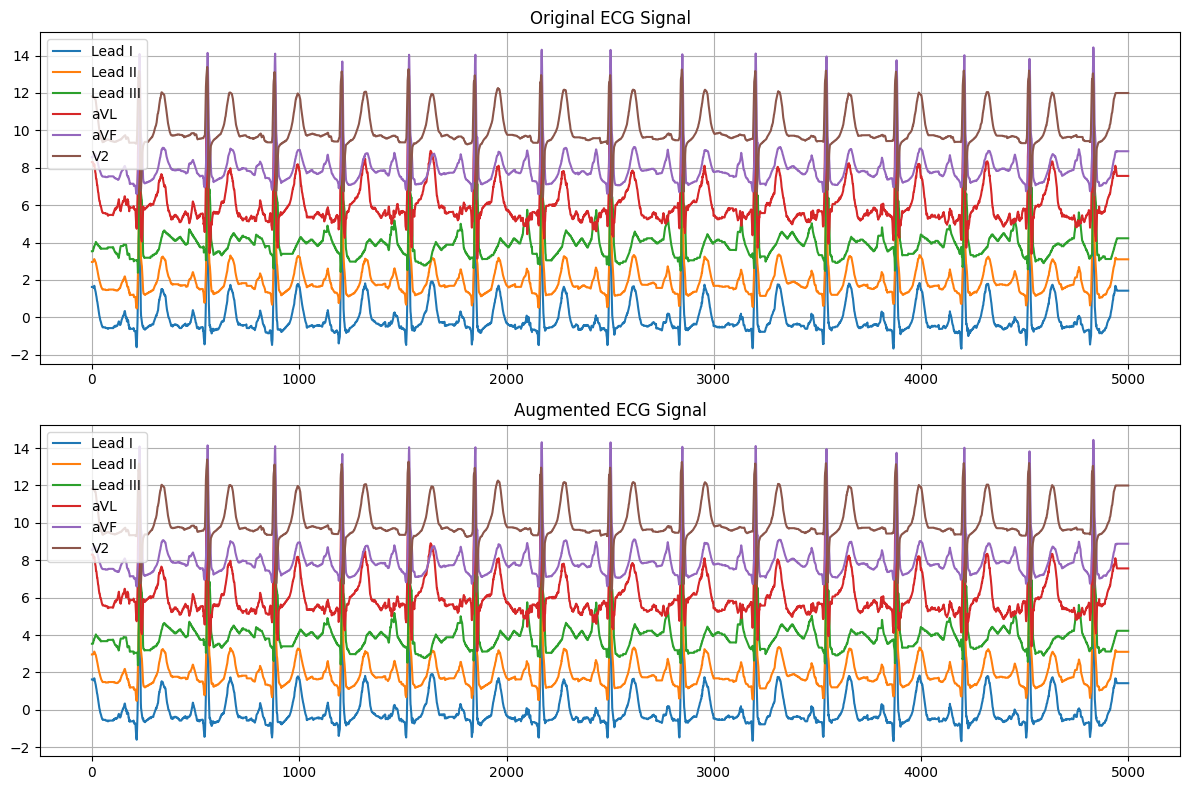

Original training set shape: (13079, 5000, 6)
Augmented training set shape: (26158, 5000, 6)


In [5]:
# Split dataset into Train/Validation/Test Sets
y = y.astype(np.float32)

#X_train, y_train, X_temp, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
#X_val, y_val, X_test, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size=0.4)
X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")


### **8️⃣ Data Augmentation for ECG Signals**
def augment_ecg_signals(ecg_batch, augment_ratio=0.5, noise_level=0.05, time_shift_max=200):
    """
    Apply data augmentation to ECG signals.
    
    Parameters:
    - ecg_batch: Batch of ECG signals with shape (batch_size, time_steps, channels)
    - augment_ratio: Fraction of samples to augment
    - noise_level: Amplitude of Gaussian noise to add
    - time_shift_max: Maximum number of steps for time shifting
    
    Returns:
    - Augmented ECG signals
    """
    batch_size = ecg_batch.shape[0]
    augmented_batch = ecg_batch.copy()
    
    # Randomly select samples to augment
    indices_to_augment = np.random.choice(
        batch_size, 
        size=int(batch_size * augment_ratio), 
        replace=False
    )
    
    for idx in indices_to_augment:
        # Randomly choose augmentation technique(s)
        techniques = np.random.choice(
            ['noise', 'time_shift', 'amplitude_scale', 'invert'], 
            size=np.random.randint(1, 3),  # Apply 1-2 techniques
            replace=False
        )
        
        signal = augmented_batch[idx].copy()
        
        # Apply selected augmentation techniques
        for technique in techniques:
            if technique == 'noise':
                # Add Gaussian noise
                noise = np.random.normal(0, noise_level, signal.shape)
                signal = signal + noise
                
            elif technique == 'time_shift':
                # Random time shift (equivalent to circular shift for ECG)
                shift_amount = np.random.randint(-time_shift_max, time_shift_max)
                signal = np.roll(signal, shift_amount, axis=0)
                
            elif technique == 'amplitude_scale':
                # Random amplitude scaling
                scale_factor = np.random.uniform(0.8, 1.2)
                signal = signal * scale_factor
                
            elif technique == 'invert':
                # Randomly invert signal (only with small probability, as this is more aggressive)
                if np.random.rand() < 0.2:  # 20% chance
                    signal = -signal
        
        augmented_batch[idx] = signal
    
    return augmented_batch

# Apply data augmentation to training data only
X_train_augmented = augment_ecg_signals(X_train)

# Visualize original vs augmented signal
plt.figure(figsize=(12, 8))
sample_idx = np.random.randint(0, len(X_train))

# Plot original signal
plt.subplot(2, 1, 1)
for i in range(X_train[sample_idx].shape[1]):
    plt.plot(X_train[sample_idx][:, i] + (i * 2), label=FOCUS_LEAD_NAMES[i])
plt.title("Original ECG Signal")
plt.legend()
plt.grid(True)

# Plot augmented signal
plt.subplot(2, 1, 2)
for i in range(X_train_augmented[sample_idx].shape[1]):
    plt.plot(X_train_augmented[sample_idx][:, i] + (i * 2), label=FOCUS_LEAD_NAMES[i])
plt.title("Augmented ECG Signal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Combine original and augmented data
X_train_combined = np.vstack([X_train, X_train_augmented])
y_train_combined = np.vstack([y_train, y_train])

print(f"Original training set shape: {X_train.shape}")
print(f"Augmented training set shape: {X_train_combined.shape}")

## Model Training

In [7]:
# Assuming X_train, y_train, X_val, y_val are defined from your preprocessing steps
input_shape = X_train.shape[1:]  # e.g., (5000, 6)
num_classes = y_train.shape[1]   # number of diagnostic classes, e.g., 5

# Define the 1D CNN model architecture
model = Sequential([
    Conv1D(filters=32, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')  # Sigmoid for multi-label classification
])

# Compile the model.
# We use binary_crossentropy loss since each label is independent (multi-label problem).
# PR-AUC and F1-Score is computed as an additional metric.
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        AUC(curve='PR', name='pr_auc', summation_method='minoring'),
        F1Score(name='f1-score')
    ]
)

model.summary()

# Define callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 5000, 32)       │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2500, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2500, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1250, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1250, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 625, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,294,053 (39.27 MB)

 Trainable params: 10,293,605 (39.27 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# Train the model
history = model.fit(
    X_train_combined, y_train_combined,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)

# Plot training & validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation PR-AUC over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['pr_auc'], label='Training PR-AUC')
plt.plot(history.history['val_pr_auc'], label='Validation PR-AUC')
plt.title('PR-AUC During Training')
plt.xlabel('Epoch')
plt.ylabel('PR-AUC')
plt.legend()
plt.grid(True)
plt.show()

: 